### Workbook -- FCNN

In this workbook, we will instantiate and train a Graph Attention Network, and compare its predictions to our old (photoz) method.

In [1]:
import numpy as np
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import time

# for aesthetics/plotting
sns.set_theme()
plt.style.use("seaborn-v0_8")

In [2]:
# Load data
from preprocess import load

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag", zmax=2)

print("Data shape [input_size, num_features]:\t", data.shape)
print("Label size [input_size,]:\t\t", labels.shape,"\n")
print("Feature names:", features)

Data shape [input_size, num_features]:	 (51255, 7)
Label size [input_size,]:		 (51255,) 

Feature names: ['res' 'u_cmodel_mag' 'g_cmodel_mag' 'r_cmodel_mag' 'i_cmodel_mag'
 'z_cmodel_mag' 'Y_cmodel_mag']


In [3]:
# Reshape data into [input_size, num_nodes, num_features_per_node] (for graphs)

data = data[:,:,np.newaxis]

print("Data shape [input_size, num_nodes, num_features_per_node]:\t", data.shape)

Data shape [input_size, num_nodes, num_features_per_node]:	 (51255, 7, 1)


Next, we will prepare our graphs using KNN

In [4]:
from preprocess import prepare_graphs

# Check for CUDA, then default to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

graphs = prepare_graphs(data, labels, k=6, device=device)

/Users/jmduchar/anaconda3/envs/final_project/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Device: cpu


100%|██████████| 801/801 [00:02<00:00, 317.18it/s]


We can visualize the resulting graphs below:

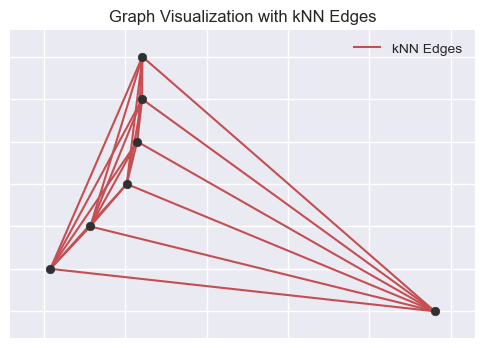

In [5]:
from visualize import visualize_graph

visualize_graph(graphs[42])

### Implementing Graph Attention Network

In [6]:
from model import GATRegression, run_model
from preprocess import split_graphs, time_elapsed

gat_model = GATRegression(7, hidden_dim=32)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01)

# Data preparation
train_set, val_set, test_set = split_graphs(graphs, 0.7, 0.15)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

loss_list = []
val_loss_list = []


t0 = time.time()
for epoch in range(1,30):

    loss = run_model(gat_model, "gat", device, train_loader, criterion, optimizer=optimizer, train=True)
    loss_list.append(loss)

    # validation
    val_loss = run_model(gat_model, "gat", device, val_loader, criterion, train=False)
    val_loss_list.append(val_loss)

    if epoch%5 == 0:
        print(f"E {epoch:02d}\t Train loss: {loss:.3f}\t "\
            + f"Val loss: {val_loss:.3f}\t t elapsed: {time_elapsed(t0,time.time())} mins"
    )


RuntimeError: mat1 and mat2 shapes cannot be multiplied (224x1 and 7x32)